In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import soepy

Use Estimated Parameters

In [2]:
model_params_est_run2 = pd.read_pickle("ressources/kids_run2_2000.pkl")
model_params = model_params_est_run2
model_params = model_params.drop(model_params.columns[1:], axis=1)

In [3]:
data_sim = soepy.simulate(
    model_params, "ressources" + "/model_spec_init_01.yml", is_expected=True
)

Get moments

In [4]:
def get_moments(data):
    # Pre_process data frame

    # Determine the education level given years of experience
    data["Educ_Level"] = 0
    data.loc[
        (data["Years_of_Education"] >= 10) & (data["Years_of_Education"] < 12),
        "Educ_Level",
    ] = 0
    data.loc[
        (data["Years_of_Education"] >= 12) & (data["Years_of_Education"] < 16),
        "Educ_Level",
    ] = 1
    data.loc[data["Years_of_Education"] >= 16, "Educ_Level"] = 2

    # Determine the observed wage given period choice
    data["Wage_Observed"] = 0
    data.loc[data["Choice"] == 0, "Wage_Observed"] = data.loc[
        data["Choice"] == 0, "Period_Wage_N"
    ]
    data.loc[data["Choice"] == 1, "Wage_Observed"] = data.loc[
        data["Choice"] == 1, "Period_Wage_P"
    ]
    data.loc[data["Choice"] == 2, "Wage_Observed"] = data.loc[
        data["Choice"] == 2, "Period_Wage_F"
    ]

    # Calculate moments

    # Initialize moments dictionary
    moments = dict()

    # Store moments in groups as nested dictionary
    for group in ["Wage_Distribution", "Choice_Probability"]:
        moments[group] = dict()

    # Compute unconditional moments of the wage distribution
    info = data.groupby(["Period"])["Wage_Observed"].describe().to_dict()

    # Save mean and standard deviation of wages for each period
    # to Wage Distribution section of the moments dictionary
    for period in range(NUM_PERIODS):  # TODO: Remove hard coded number
        moments["Wage_Distribution"][period] = []
        try:
            for label in ["mean", "std"]:
                moments["Wage_Distribution"][period].append(info[label][period])
        except KeyError:
            for i in range(2):
                moments["Wage_Distribution"][period].append(0.0)

    # Compute unconditional moments of the choice probabilities
    info = data.groupby(["Period"])["Choice"].value_counts(normalize=True).to_dict()

    for period in range(NUM_PERIODS):  # TODO: Remove hard coded number
        moments["Choice_Probability"][period] = []
        for choice in range(3):
            try:
                stat = info[(period, choice)]
            except KeyError:
                stat = 0.00
            moments["Choice_Probability"][period].append(stat)

    return moments

In [5]:
NUM_PERIODS = 30

In [6]:
# Get simulated(estimates) and observed moments

moments_sim = get_moments(data_sim)

# Get observed moments
with open("ressources" + "/moments_obs_extended.pkl", "rb") as f:
    moments_obs = pickle.load(f)

Model fit

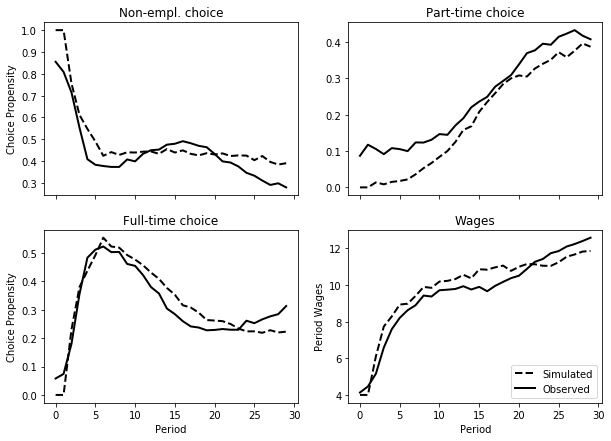

In [7]:

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 7))
#fig.suptitle('Model fit')

#########
for choice in range(3):

    obs_choice_prob = []
    for _, value in moments_obs["Choice_Probability"].items():
        temp = [_, value]
        obs_choice_prob.append(temp[1][choice])

    sim_choice_prob = []
    for _, value in moments_sim["Choice_Probability"].items():
        temp = [_, value]
        sim_choice_prob.append(temp[1][choice])

    x = np.arange(30)

    # Start plot
    if choice == 0:
        axs[0, 0].plot(x, sim_choice_prob, color="k", linestyle= "--", linewidth= 2.0)
        axs[0, 0].plot(x, obs_choice_prob, color="k", linewidth= 2.0)
        axs[0, 0].set_title('Non-empl. choice')
        axs[0, 0].set_ylabel("Choice Propensity")
    
    if choice == 1:
        axs[0, 1].plot(x, sim_choice_prob, color="k", linestyle= "--", linewidth= 2.0)
        axs[0, 1].plot(x, obs_choice_prob, color="k", linewidth= 2.0)
        axs[0, 1].set_title('Part-time choice')
    
    if choice == 2:
        axs[1, 0].plot(x, sim_choice_prob, color="k", linestyle= "--", linewidth= 2.0)
        axs[1, 0].plot(x, obs_choice_prob, color="k", linewidth= 2.0)
        axs[1, 0].set_title('Full-time choice')
        axs[1, 0].set_ylabel("Choice Propensity")
        axs[1, 0].set_xlabel("Period")

### Wages
obs_wages = []
for _, value in moments_obs["Wage_Distribution"].items():
    temp = [_, value]
    obs_wages.append(temp[1][0])

sim_wages = []
for _, value in moments_sim["Wage_Distribution"].items():
    temp = [_, value]
    sim_wages.append(temp[1][0])

x = np.arange(30)

# Start plot
axs[1, 1].plot(x, sim_wages, color="k", linestyle= "--", linewidth= 2.0)
axs[1, 1].plot(x, obs_wages, color="k", linewidth= 2.0)
axs[1, 1].set_title('Wages')
axs[1, 1].set_ylabel("Period Wages")
axs[1, 1].set_xlabel("Period")
axs[1, 1].legend(["Simulated", "Observed"], loc = 'lower right')


Point 1: Analysis by education
------------------------------------

Currently all individuals with low level of education are estimated/simulated to be not employed in all periods. This is one reason why the model fit is not perfect and, importantly, the reason why I have so far refrained from showing plots by level of education in presentations.

The problem: One obvious driver of the problem is that currently the rewards for the non-employment option are not estimated endogenously, but are set as fixed value that is valid for all individuals and all periods.

Possible solutions:
a) estimate non-employment benefits fully endogenously.
b) model non-employment rewards as fixed benefits + error term the variance of which is estimated endogenously.

In [8]:
# Probability to be non-employed if educ level is low for all periods
data_sim[data_sim["Educ_Level"] == 0].groupby(['Period'])['Choice'].value_counts(normalize=True)

Period  Choice
0.0     0.0       1.0
1.0     0.0       1.0
2.0     0.0       1.0
3.0     0.0       1.0
4.0     0.0       1.0
5.0     0.0       1.0
6.0     0.0       1.0
7.0     0.0       1.0
8.0     0.0       1.0
9.0     0.0       1.0
10.0    0.0       1.0
11.0    0.0       1.0
12.0    0.0       1.0
13.0    0.0       1.0
14.0    0.0       1.0
15.0    0.0       1.0
16.0    0.0       1.0
17.0    0.0       1.0
18.0    0.0       1.0
19.0    0.0       1.0
20.0    0.0       1.0
21.0    0.0       1.0
22.0    0.0       1.0
23.0    0.0       1.0
24.0    0.0       1.0
25.0    0.0       1.0
26.0    0.0       1.0
27.0    0.0       1.0
28.0    0.0       1.0
29.0    0.0       1.0
Name: Choice, dtype: float64

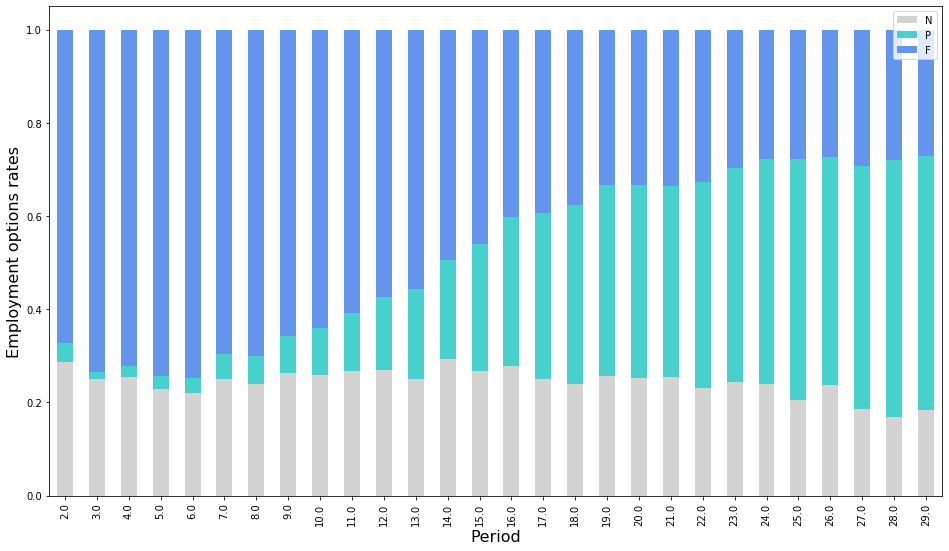

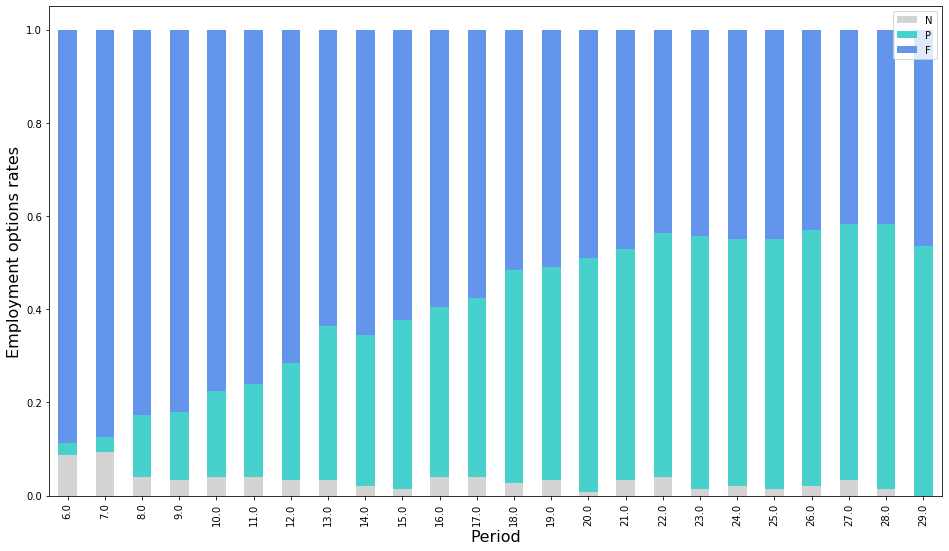

In [9]:
# In contrast, this how probabilities look like for the other two education levels
for i in [1,2]:
    
    ax = plt.figure(figsize=[16,9]).add_subplot(111)
    ax.set_ylabel("Employment options rates", fontsize=16)
    ax.set_xlabel("Period", fontsize=16)

    data_sim[data_sim["Educ_Level"] == i].groupby(['Period'])['Choice'].value_counts(normalize=True).unstack().plot(ax = ax, kind = 'bar', stacked = True, color=('lightgrey', 'mediumturquoise', 'cornflowerblue'))

    ax.legend(["N", "P", "F"])

Point 2: Persistene - actually looks good!
------------------------------------------------

- ideas of alternative ways to show/investigate persistance?

Import observed data

In [10]:
data_full = pd.read_stata("ressources/soepcore_prep.dta")

In [11]:
def pre_process_soep_data(file_name):
    data_full = pd.read_stata(file_name)

    # Restrict sample to age 50
    data_30periods = data_full[data_full["age"] < 47]

    # Restirct sample to west Germany
    data = data_30periods[data_30periods["east"] == 0]

    # Drop observations with missing values in hdegree
    data = data[data["hdegree"].isna() == False]

    # Generate period variable
    def get_period(row):
        return row["age"] - 17

    data["Period"] = data.apply(
        lambda row: get_period(row), axis=1
    )

    # Determine the observed wage given period choice
    def recode_educ_level(row):
        if row["hdegree"] == 'Primary/basic vocational':
            return 0
        elif row["hdegree"] == 'Abi/intermediate voc.':
            return 1
        elif row["hdegree"] == 'University':
            return 2
        else:
            return np.nan

    data["Educ Level"] = data.apply(
        lambda row: recode_educ_level(row), axis=1
    )

    # Recode choice
    # Determine the observed wage given period choice
    def recode_choice(row):
        if row["empchoice"] == 'Full-Time':
            return 2
        elif row["empchoice"] == 'Part-Time':
            return 1
        elif row["empchoice"] == 'Non-Working':
            return 0
        else:
            return np.nan

    data["Choice"] = data.apply(
        lambda row: recode_choice(row), axis=1
    )

    # Generate wage for Non-Employment choice
    data["wage_nw_imp"] = 6.00

    # Determine the observed wage given period choice
    def get_observed_wage(row):
        if row["empchoice"] == 'Full-Time':
            return row["wage_ft"]
        elif row["empchoice"] == 'Part-Time':
            return row["wage_pt"]
        elif row["empchoice"] == 'Non-Working':
            return row["wage_nw_imp"]
        else:
            return np.nan

    data["Wage Observed"] = data.apply(
        lambda row: get_observed_wage(row), axis=1
    )

    return data

In [12]:
data_obs = pre_process_soep_data("ressources/soepcore_prep.dta")

Split observed data in "full-timers" and "part-timers"

In [13]:
pt_id = list(data_obs[(data_obs['Period'] == 29) & (data_obs['Choice'] == 1)]['pid'])
ft_id = list(data_obs[(data_obs['Period'] == 29) & (data_obs['Choice'] == 2)]['pid'])

In [14]:
data_pt = pd.DataFrame()
for i in range(len(pt_id)):
    person_data = data_obs[data_obs['pid'] == pt_id[i]]
    data_pt = data_pt.append(person_data)
    
data_ft = pd.DataFrame()
for i in range(len(ft_id)):
    person_data = data_obs[data_obs['pid'] == ft_id[i]]
    data_ft = data_ft.append(person_data)

Split simulated data in part-timers and full-timers

In [15]:
pt_id = list(data_sim[(data_sim['Period'] == 29) & (data_sim['Choice'] == 1)]['Identifier'])
ft_id = list(data_sim[(data_sim['Period'] == 29) & (data_sim['Choice'] == 2)]['Identifier'])

In [16]:
data_sim_pt = pd.DataFrame()
for i in range(len(pt_id)):
    person_data = data_sim[data_sim['Identifier'] == pt_id[i]]
    data_sim_pt = data_sim_pt.append(person_data)
    
data_sim_ft = pd.DataFrame()
for i in range(len(ft_id)):
    person_data = data_sim[data_sim['Identifier'] == ft_id[i]]
    data_sim_ft = data_sim_ft.append(person_data)

Compare persistance

Part-timers

In [17]:
# Observed
# Average years of experience in part-time and full-time among 'part-timers'
(data_pt[data_pt['Period'] == 29]['exper_pt'].describe()['mean'],
 #data_pt[data_pt['Period'] == 29]['exper_pt'].describe()['std'],
 data_pt[data_pt['Period'] == 29]['exper_ft'].describe()['mean'],
 #data_pt[data_pt['Period'] == 29]['exper_ft'].describe()['std']
)

(9.412765957446808, 8.872340425531915)

In [18]:
# Estimated
# Average years of experience in part-time and full-time among 'part-timers'
(data_sim_pt[data_sim_pt['Choice'] == 1].groupby(['Identifier'])['Period'].count().mean(),
 data_sim_pt[data_sim_pt['Choice'] == 2].groupby(['Identifier'])['Period'].count().mean())

(11.695090439276486, 9.036458333333334)

Full-timers

In [19]:
# Observed
# Average years of experience in part-time and full-time among 'full-timers'
(data_ft[data_ft['Period'] == 29]['exper_pt'].describe()['mean'],
 #data_ft[data_ft['Period'] == 29]['exper_pt'].describe()['std'],
 data_ft[data_ft['Period'] == 29]['exper_ft'].describe()['mean'],
 #data_ft[data_ft['Period'] == 29]['exper_ft'].describe()['std']
)

(3.111576011157601, 17.880055788005578)

In [20]:
# Estimated
# Average years of experience in part-time and full-time among 'full-timers'
(data_sim_ft[data_sim_ft['Choice'] == 1].groupby(['Identifier'])['Period'].count().mean(),
 data_sim_ft[data_sim_ft['Choice'] == 2].groupby(['Identifier'])['Period'].count().mean())

(2.4397590361445785, 20.905829596412556)